In [1]:
import numpy as np

from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, Operator
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
sim = AerSimulator()

from util import zero, one

# QI: Superdense Coding

In this notebook, we'll introduce **superdense coding**. It is a protocol that enables two parties to share two classical bits of information using a shared and entangled qubit.

References
1. [Qiskit Notebook on Superdense Coding](https://learn.qiskit.org/course/ch-algorithms/superdense-coding)
2. [Introduction to Quantum Information Science: Lecture 9 by Scott Aaronson](https://www.scottaaronson.com/qclec.pdf)
3. [Quantum Computation and Quantum Information: Chapter 2, Nielsen and Chuang](https://www.cambridge.org/highereducation/books/quantum-computation-and-quantum-information/01E10196D0A682A6AEFFEA52D53BE9AE#overview)

## Protocol

The superdense coding protocol involves
1. an entangled qubit that Alice and Bob will share,
2. a message encoding step that Alice will apply to a send a message, and
3. a message decoding step that Bob will apply to decode the sent message.

### Part 1: Create Bell State

1. We need a third party, Charlie, to create an entangled bell state.
2. Charlie will send qubit $|q_1\rangle$ to Alice.
3. Charlie will send qubit $|q_0\rangle$ to Bob.

In [2]:
def create_alice_bob() -> QuantumCircuit:
    alice_qubit = QuantumRegister(1, "q_Alice")
    bob_qubit = QuantumRegister(1, "q_Bob")
    return QuantumCircuit(bob_qubit, alice_qubit)

In [3]:
def create_bell_state(qc: QuantumCircuit) -> QuantumCircuit:
    qc.h(1)
    qc.cx(1, 0)
    return qc

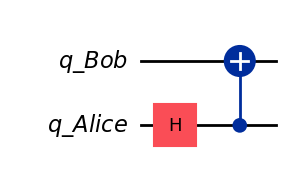

In [4]:
create_bell_state(create_alice_bob()).draw(output="mpl", style="iqp")

### Part 2: Encode Message

Alice will use the following encoding scheme to encode classical bits into quantum state.
1. 00: $\frac{1}{\sqrt{2}}|00\rangle + \frac{1}{\sqrt{2}}|11\rangle$
2. 10: $\frac{1}{\sqrt{2}}|00\rangle - \frac{1}{\sqrt{2}}|11\rangle$
3. 01: $\frac{1}{\sqrt{2}}|01\rangle + \frac{1}{\sqrt{2}}|10\rangle$
4. 11: $\frac{1}{\sqrt{2}}|01\rangle - \frac{1}{\sqrt{2}}|10\rangle$

To implement this coding scheme, Alice can use a message-specific quantum circuit.
Thus she will end up with four circuits.

In [5]:
def encode_message(qc, msg: str) -> QuantumCircuit:
    # Adapted from: https://learn.qiskit.org/course/ch-algorithms/superdense-coding
    # Create quantum circuit that sends `msg`
    if len(msg) != 2 or not set(msg).issubset({"0", "1"}):
        raise ValueError(f"message '{msg}' is invalid")
                
    # Encode message
    if msg[1] == "1":
        qc.x(1)
    if msg[0] == "1":
        qc.z(1)
    if msg[0] == "0" and msg[1] == "0":
        qc.id(1)
    return qc

#### Messsage 00

The message for `00` is given by

$$
I (\frac{1}{\sqrt{2}}|00\rangle + \frac{1}{\sqrt{2}}|11\rangle) = \frac{1}{\sqrt{2}}|00\rangle + \frac{1}{\sqrt{2}}|11\rangle
$$

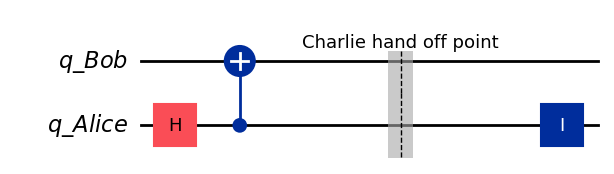

In [6]:
message = "00"
qc_00 = create_bell_state(create_alice_bob())
qc_00.barrier(label="Charlie hand off point")
qc_00 = encode_message(qc_00, message)
qc_00.draw(output="mpl", style="iqp")

In [7]:
m_00 = (zero ^ zero).evolve(qc_00)
m_00.draw("latex")

<IPython.core.display.Latex object>

#### Messsage 10

The message for `10` is given by

$$
(Z \otimes I) (|00\rangle + \frac{1}{\sqrt{2}}|11\rangle) = \frac{1}{\sqrt{2}}|00\rangle - \frac{1}{\sqrt{2}}|11\rangle \,.
$$

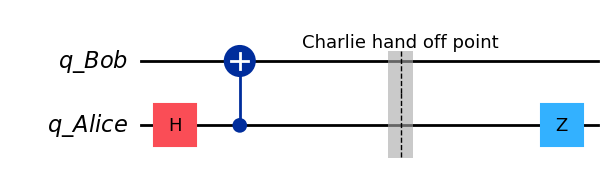

In [8]:
message = "10"
qc_10 = create_bell_state(create_alice_bob())
qc_10.barrier(label="Charlie hand off point")
qc_10 = encode_message(qc_10, message)
qc_10.draw(output="mpl", style="iqp")

In [9]:
m_10 = (zero ^ zero).evolve(qc_10)
m_10.draw("latex")

<IPython.core.display.Latex object>

#### Messsage 01

The message for `01` is given by

$$
(X \otimes I) |00\rangle + \frac{1}{\sqrt{2}}|11\rangle) = \frac{1}{\sqrt{2}}|01\rangle + \frac{1}{\sqrt{2}}|10\rangle
$$

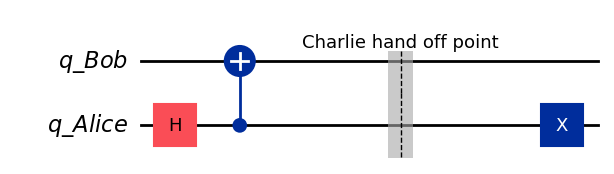

In [10]:
message = "01"
qc_01 = create_bell_state(create_alice_bob())
qc_01.barrier(label="Charlie hand off point")
qc_01 = encode_message(qc_01, message)
qc_01.draw(output="mpl", style="iqp")

In [11]:
m_01 = (zero ^ zero).evolve(qc_01)
m_01.draw("latex")

<IPython.core.display.Latex object>

#### Messsage 11

The message for `11` is given by

$$
(ZX \otimes I) (|00\rangle + \frac{1}{\sqrt{2}}|11\rangle) = \frac{1}{\sqrt{2}}|01\rangle - \frac{1}{\sqrt{2}}|10\rangle
$$

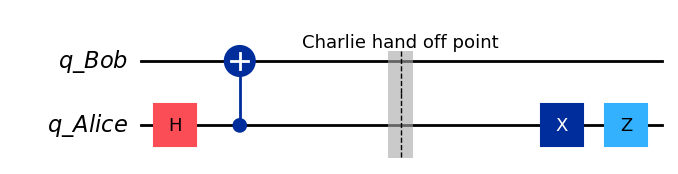

In [12]:
message = "11"
qc_11 = create_bell_state(create_alice_bob())
qc_11.barrier(label="Charlie hand off point")
qc_11 = encode_message(qc_11, message)
qc_11.draw(output="mpl", style="iqp")

In [13]:
m_11 = (zero ^ zero).evolve(qc_11)
m_11.draw("latex")

<IPython.core.display.Latex object>

#### Observation 1: All messages are orthogonal

The messages are all orthogonal to each other.

In [14]:
# Orthogonality check
messages = [m_00, m_10, m_01, m_11]
for i, m1 in enumerate(messages):
    for j, m2 in enumerate(messages):
        if i != j and not np.allclose(np.dot(m_00, m_01), [0]):
            print("Not orthogonal", m1, m2)

#### Observation 2: Ambiguity

Although the encoding of the message for `01` and `11` are orthogonal, we still cannot distinguish them by measurement unless we choose an appropriate basis. We demonstrate the ambiguity in distinguishing `01` and `11` now.

In [15]:
def test_encode_message(msg):
    qc = QuantumCircuit(2, 2)
    qc = create_bell_state(qc)
    qc = encode_message(qc, msg)
    qc.measure(0, 0); qc.measure(1, 1)
    result = sim.run(qc).result()
    counts = result.get_counts(qc)
    return counts, qc

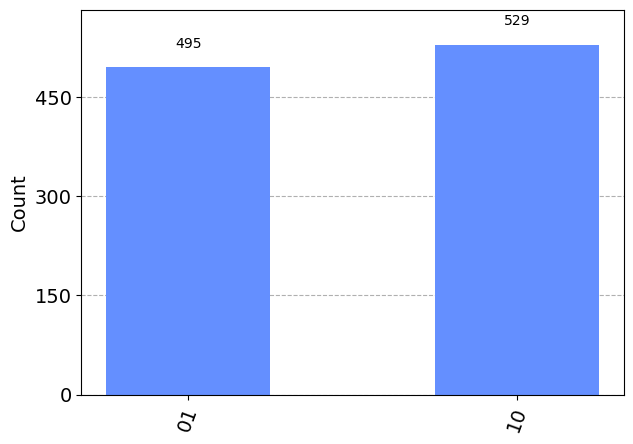

In [16]:
counts, qc = test_encode_message("01")
plot_histogram(counts)

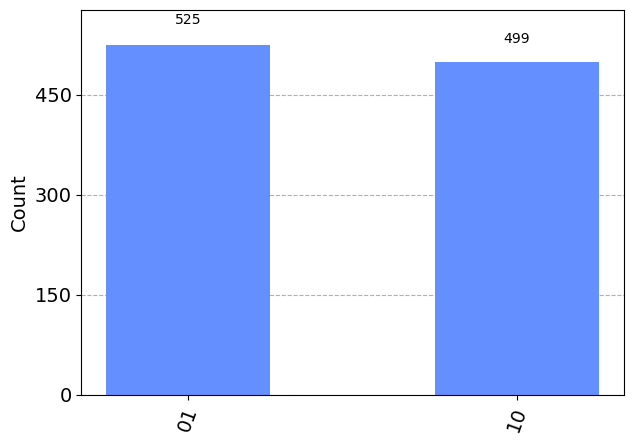

In [17]:
# Gives same histogram as 10
counts, qc = test_encode_message("11")
plot_histogram(counts)

### Part 3: Decode Message

After Alice encodes the message, Charlie will transport the qubit from Alice to Bob. Thus Bob will have both qubits now. However, Bob cannot directly measure the qubits to the get the results due to the ambiguity in distinguishing `01` from `11`. Instead, Bob will need to perform decoding in an appropriate basis. This is accomplished with the circuit below.

In [18]:
def decode_message(qc: QuantumCircuit) -> QuantumCircuit:
    qc.cx(1, 0)
    qc.h(1)
    return qc

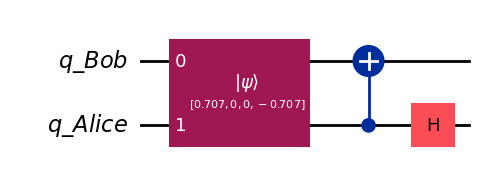

In [19]:
qc_10 = create_alice_bob()
qc_10.initialize(m_10)
qc_10 = decode_message(qc_10)
qc_10.draw(output="mpl", style="iqp")

In [20]:
(zero ^ zero).evolve(qc_10).draw('latex')

<IPython.core.display.Latex object>

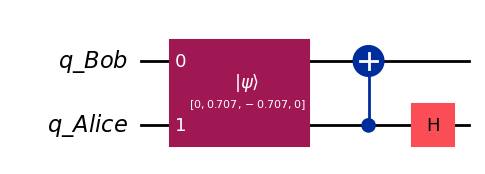

In [21]:
qc_11 = create_alice_bob()
qc_11.initialize(m_11)
qc_11 = decode_message(qc_11)
qc_11.draw(output="mpl", style="iqp")

In [22]:
(zero ^ zero).evolve(qc_11).draw('latex')

<IPython.core.display.Latex object>

### Why does this work?

1. If Bob obtains $\frac{1}{\sqrt{2}}|00\rangle + \frac{1}{\sqrt{2}}|11\rangle$ (for `00`), then

\begin{align*}
(H \otimes I) CNOT (\frac{1}{\sqrt{2}}|00\rangle + \frac{1}{\sqrt{2}}|11\rangle) & = (H \otimes I) (|+\rangle \otimes |0\rangle) \\
& = |0\rangle \otimes |0\rangle \,.
\end{align*}

2. If Bob obtains $\frac{1}{\sqrt{2}}|00\rangle - \frac{1}{\sqrt{2}}|11\rangle$ (for `10`), then

\begin{align*}
(H \otimes I) CNOT (\frac{1}{\sqrt{2}}|00\rangle + \frac{1}{\sqrt{2}}|11\rangle) & = (H \otimes I) (|-\rangle \otimes |0\rangle) \\
& = |1\rangle \otimes |0\rangle \,.
\end{align*}


3. If Bob obtains $\frac{1}{\sqrt{2}}|01\rangle + \frac{1}{\sqrt{2}}|10\rangle$ (for `01`), then

\begin{align*}
(H \otimes I) CNOT (\frac{1}{\sqrt{2}}|01\rangle + \frac{1}{\sqrt{2}}|10\rangle) & = (H \otimes I) (|+\rangle \otimes |1\rangle) \\
& = |0\rangle \otimes |1\rangle \,.
\end{align*}

4. If Bob obtains $\frac{1}{\sqrt{2}}|01\rangle - \frac{1}{\sqrt{2}}|10\rangle$ (for `11`), then

\begin{align*}
(H \otimes I) CNOT (\frac{1}{\sqrt{2}}|01\rangle - \frac{1}{\sqrt{2}}|10\rangle) & = (H \otimes I) (|-\rangle \otimes |1\rangle) \\
& = |1\rangle \otimes |1\rangle \,.
\end{align*}


## Putting it Together

We put the entire protocol together for end-to-end experimentation.

In [23]:
def superdense_coding(msg: str):
    alice_qubit = QuantumRegister(1, "q_Alice")
    bob_qubit = QuantumRegister(1, "q_Bob")
    result = ClassicalRegister(2, "decode")
    qc = QuantumCircuit(bob_qubit, alice_qubit, result)

    # Part 1: Third party creates entangled state
    qc = create_bell_state(qc)
    qc.barrier(label="Charlie hand off point")
    
    # Part 2: Alice encode message on qubit 1
    qc = encode_message(qc, msg)
    qc.barrier(label="Charlie sends \nAlice's qubit to Bob")
    
    # Part 3: Bob puts in basis and measures
    qc = decode_message(qc)
    qc.measure(0, 0); qc.measure(1, 1)

    result = sim.run(qc).result()
    counts = result.get_counts(qc)
    return counts, qc

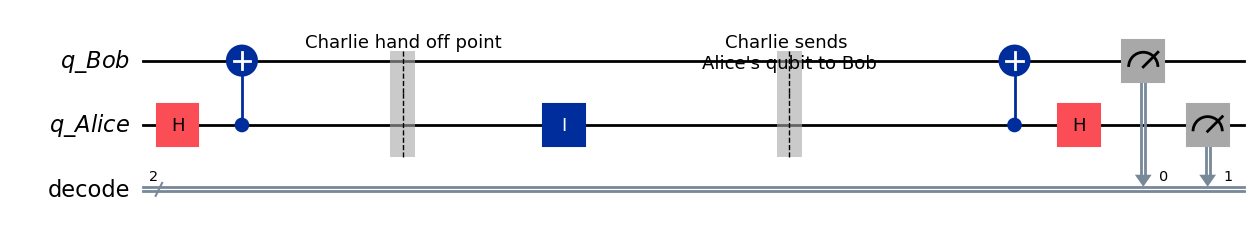

In [24]:
counts, qc = superdense_coding("00")
qc.draw(output="mpl", style="iqp")

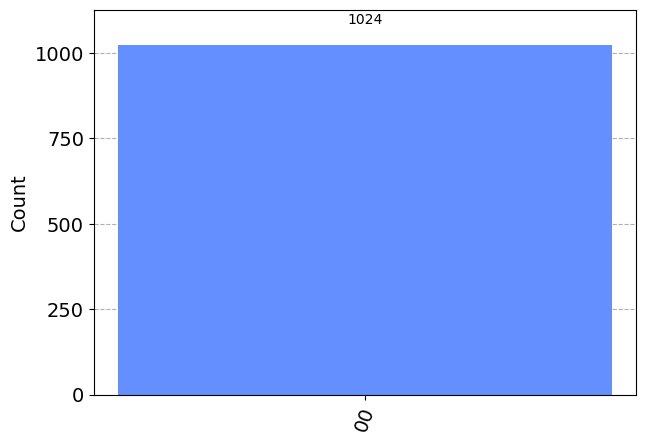

In [25]:
plot_histogram(counts)

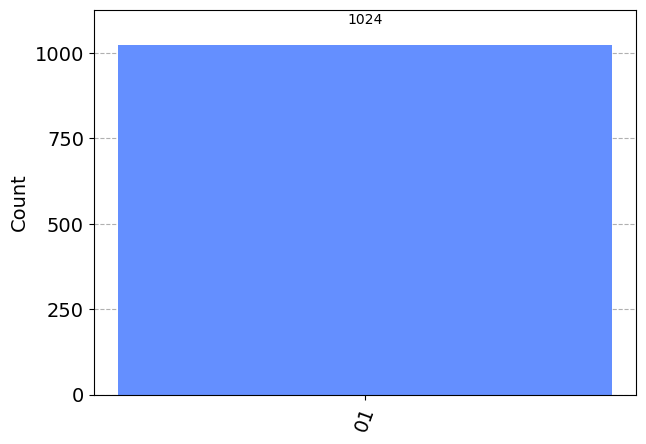

In [26]:
# Change message
message = "01"
counts, qc = superdense_coding(message)
plot_histogram(counts)

## Summary

1. First example of quantum protocol. 
2. We were able to transmit 2 classical bits using 1 entangled qubit.
3. Thus we have a quantum system that is split across two parties.